# Summary

## Objective

Study the capacity of Reservoir Computing (RC) to model longitudinal health data with mixed effects.  

In other word: do the modelisation of complex time dependecies can compensate the lack of direct modelisation of the random effect?

## Method

### Sub-studies


4 sub-studies have been done:
- SF x FE
- SF x ME
- AF x FE
- AF x ME

With:  
- SF = "Simple Features" $\Rightarrow x_2 * x_5$, $x_4 * x_7$, $x_6 * x_8$  
- AF = "All Features" $\Rightarrow x_1,…,x_8$  

And:  
- FE = "Fixed Effect (with noise)" $\Rightarrow y_{fixed,obs}$
- ME = "Mixed Effect (with noise) $\Rightarrow y_{mixed,obs}$  

## 



### Hyper-parameters optimization

From *Unsupervised Reservoir Computing for Solving Ordinary Differential Equations*:  
> Training an RC is efficient, however, finding the optimal hyper-parameters that determine the weight distributions and the network architecture is challenging. RC performance strongly depends on these hyper-parameters and, therefore, finding good hyper-parameters is crucial. The RC has many hyper-parameters making this a computationally expensive process.


We will use Optuna for the hyper-parameters optimization.

**trial**: set of hyperparameters suggested by Optuna   
**warmup**: first timesteps that are ignore in the computation of the loss and error


**The method**:
```
for each trial:
    for 5 random seeds:
        generate the reservoir
        train the reservoir on X_train and Y_train
        predict using the reservoir on X_val
        compute the MSE between Y_val and Y_pred: MSE_seed 
    compute MSE_trial = mean(MSE_seed)
return the best trial corresponding to min(MSE_trial)
```


**Note on Optuna's TPESampler**:  

https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html  
> Sampler using TPE (Tree-structured Parzen Estimator) algorithm.  
On each trial, for each parameter, TPE fits one Gaussian Mixture Model (GMM) $l(x)$ to the set of parameter values associated with the best objective values, and another GMM $g(x$) to the remaining parameter values. It chooses the parameter value x that maximizes the ratio $l(x)/g(x)$.


https://anna-ssi.github.io/blog/tpe/  
> Tree-structured Parzen Estimators (TPE) derive their name from the **combination of Parzen estimators to model the probability distributions of hyperparameters and a structured, graph-like approach to represent hyperparameter configurations**. In this tree-like representation, each hyperparameter is a node, and edges denote the dependencies between them.  
For example, the choice of the optimizer (e.g., Adam) and the learning rate can be seen as interconnected nodes.  
This structured representation allows TPE to focus on updating only the relevant parts of the model when new observations are made.  
It also facilitates establishing **dependencies among random variables**, making conditional sampling more efficient and enabling the algorithm to optimize the search space faster.

# Baseline => Capacity

We use:
- features:
  - "x2_x5" and "x4_x7"
  - without noise
- target without random effects

In [8]:
STUDY_NAME = "Cheat-Capacity"
db_name = f"{STUDY_NAME}.db"
df_name = f"{STUDY_NAME}.pkl"
# %rm "$db_name"
storage_name = f"sqlite:///{db_name}"

x_labels = ["x2_x5", "x4_x7"]
data_train = data_test = data
y_labels_train = y_labels_test = ["y_fixed"]

processed_data = ProcessedData(
    data_train,
    data_test,
    SERIES_COLUMN_NAME,
    TIMESTEPS_COLUMN_NAME,
    x_labels,
    y_labels_train,
    y_labels_test,
    RobustScaler(),
)

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize"],
    load_if_exists=True,
)

if not study.trials:

    study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
        n_trials=100,
    )

#######################
# study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
# study.optimize(
#     lambda x: optuna_objective(x, processed_data),
#     n_trials=100,
# )
######################

print(f"\n{len(study.trials)} trials found.")

print(f"\nThe best model MSE is: {study.best_value:.2e}")

Train and test data prepared with scaler <class 'sklearn.preprocessing._data.RobustScaler'>.


[I 2024-11-13 15:41:07,095] Using an existing study with name 'Cheat-Capacity' instead of creating a new one.



229 trials found.

The best model MSE is: 8.62e-26


## Predictions of the best model

In [9]:
# if Path(df_name).exists() and (
#     Path(df_name).stat().st_mtime > Path(db_name).stat().st_mtime
# ):
#     df_pred = pd.read_pickle(df_name)
#     print(f"'{df_name}' opened")
# else:
#     best_model_list = get_model_list(study.best_trial, x_labels)
#     df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=N_CPUS)
#     df_pred.to_pickle(df_name)

### Worst individual predictions of the best model

In [11]:
# for indiv in get_worst_individuals(
#     df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
# ):
#     plot_individual_results(
#         df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
#     )

## Hyper-parameters analysis

/tmp/ipykernel_17253/2091147769.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])


array([<Axes: xlabel='N', ylabel='Objective Value'>, <Axes: xlabel='lr'>,
       <Axes: xlabel='ridge'>, <Axes: xlabel='sr'>], dtype=object)

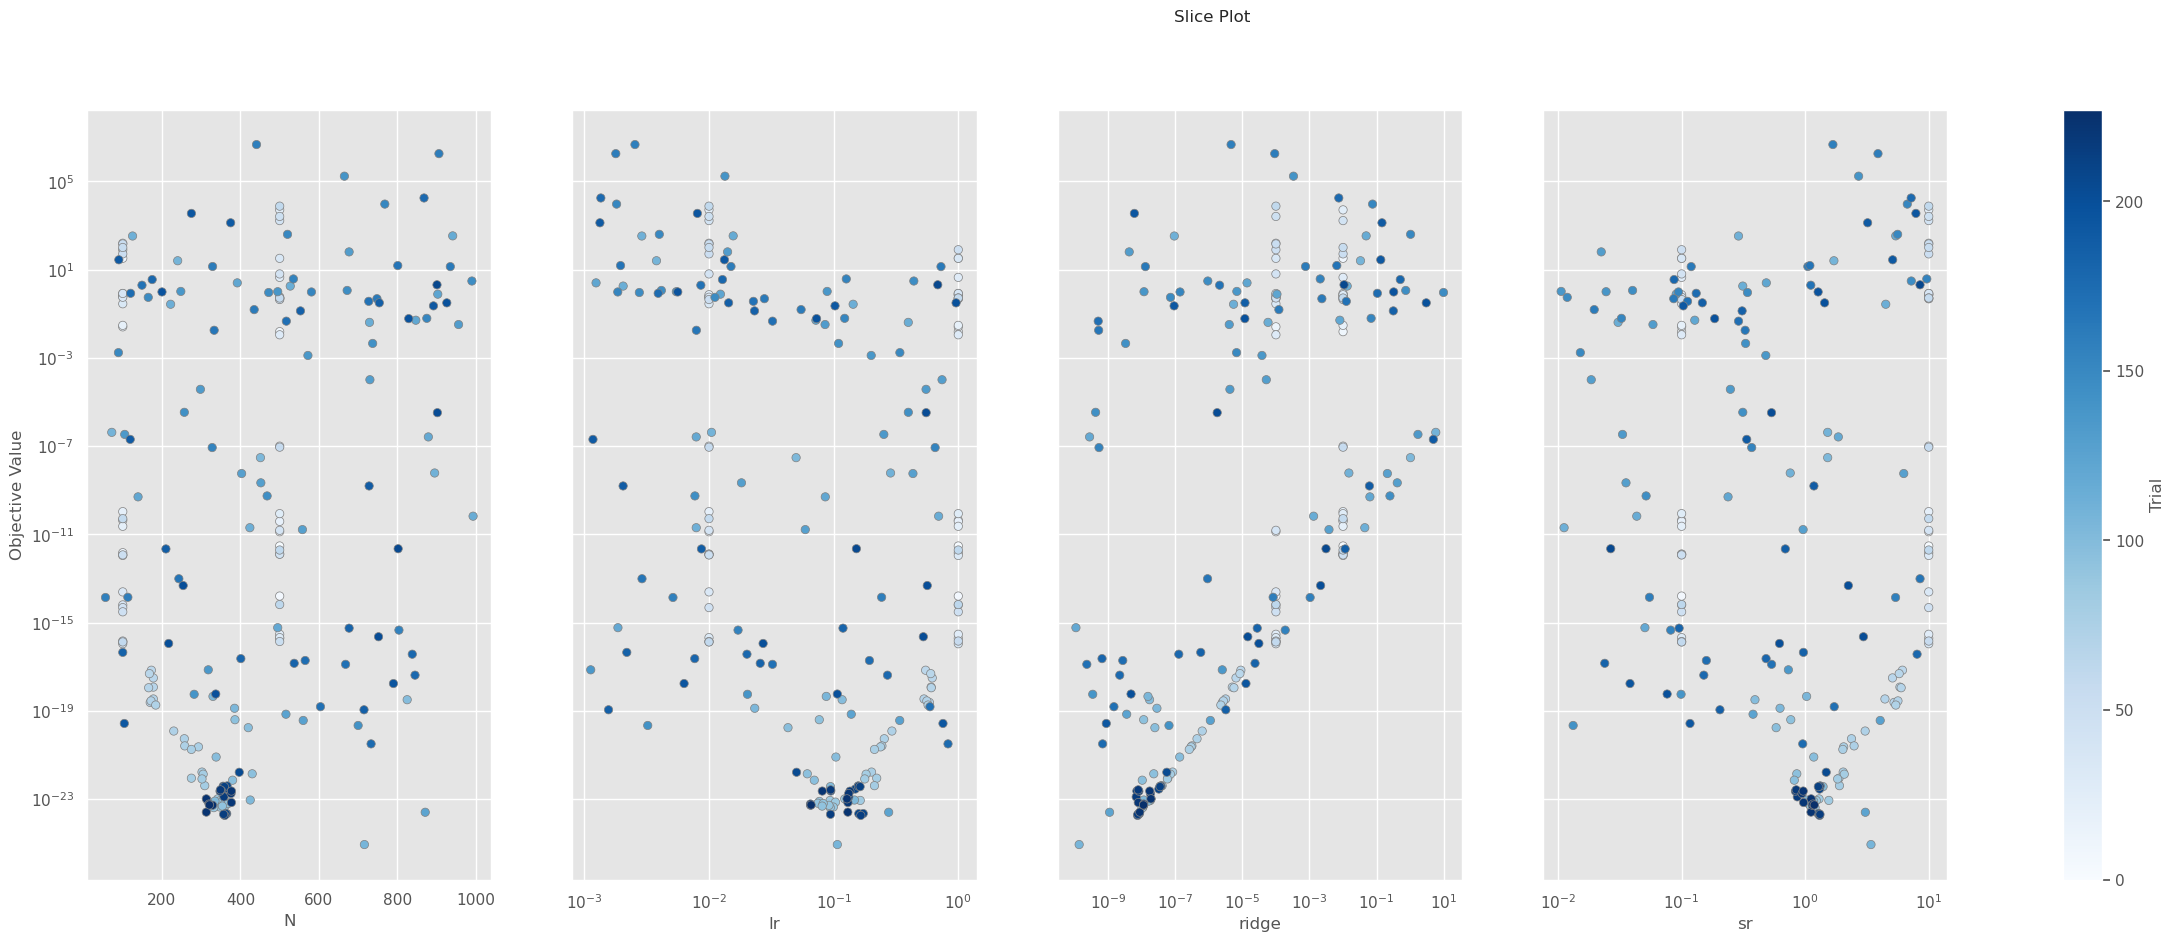

In [12]:
axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
ax = axes[0]
ax.set_yscale("log")
axes

# Baseline => Generalization 

In [13]:
STUDY_NAME = "Cheat-Generalization"
db_name = f"{STUDY_NAME}.db"
df_name = f"{STUDY_NAME}.pkl"
# %rm "$db_name"
storage_name = f"sqlite:///{db_name}"

x_labels = ["x2_x5", "x4_x7"]
y_labels_train = ["y_fixed"]
y_labels_test = ["y_fixed"]


indiv_list = data[SERIES_COLUMN_NAME].unique()
N_indiv = len(indiv_list)
indiv_cut = round(0.8 * N_indiv)

data_train = data[data[SERIES_COLUMN_NAME] < indiv_cut]
data_test = data[data[SERIES_COLUMN_NAME] >= indiv_cut]

processed_data = ProcessedData(
    data_train,
    data_test,
    SERIES_COLUMN_NAME,
    TIMESTEPS_COLUMN_NAME,
    x_labels,
    y_labels_train,
    y_labels_test,
    RobustScaler(),
)

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize"],
    load_if_exists=True,
)

if not study.trials:

    study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
        n_trials=100,
    )

#######################
# study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
# study.optimize(
#     lambda x: optuna_objective(x, processed_data),
#     n_trials=100,
# )
######################

print(f"\n{len(study.trials)} trials found.")

print(f"\nThe best model MSE is: {study.best_value:.2e}")

[I 2024-11-13 15:41:09,893] Using an existing study with name 'Cheat-Generalization' instead of creating a new one.


Train and test data prepared with scaler <class 'sklearn.preprocessing._data.RobustScaler'>.

179 trials found.

The best model MSE is: 1.03e-23


## Predictions of the best model

In [14]:
# if Path(df_name).exists() and (
#     Path(df_name).stat().st_mtime > Path(db_name).stat().st_mtime
# ):
#     df_pred = pd.read_pickle(df_name)
#     print(f"'{df_name}' opened")
# else:
#     best_model_list = get_model_list(study.best_trial, x_labels)
#     df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=N_CPUS)
#     df_pred.to_pickle(df_name)

### Worst individual predictions of the best model

In [16]:
# for indiv in get_worst_individuals(
#     df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
# ):
#     plot_individual_results(
#         df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
#     )

## Hyper-parameters analysis

/tmp/ipykernel_17253/3621283914.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])


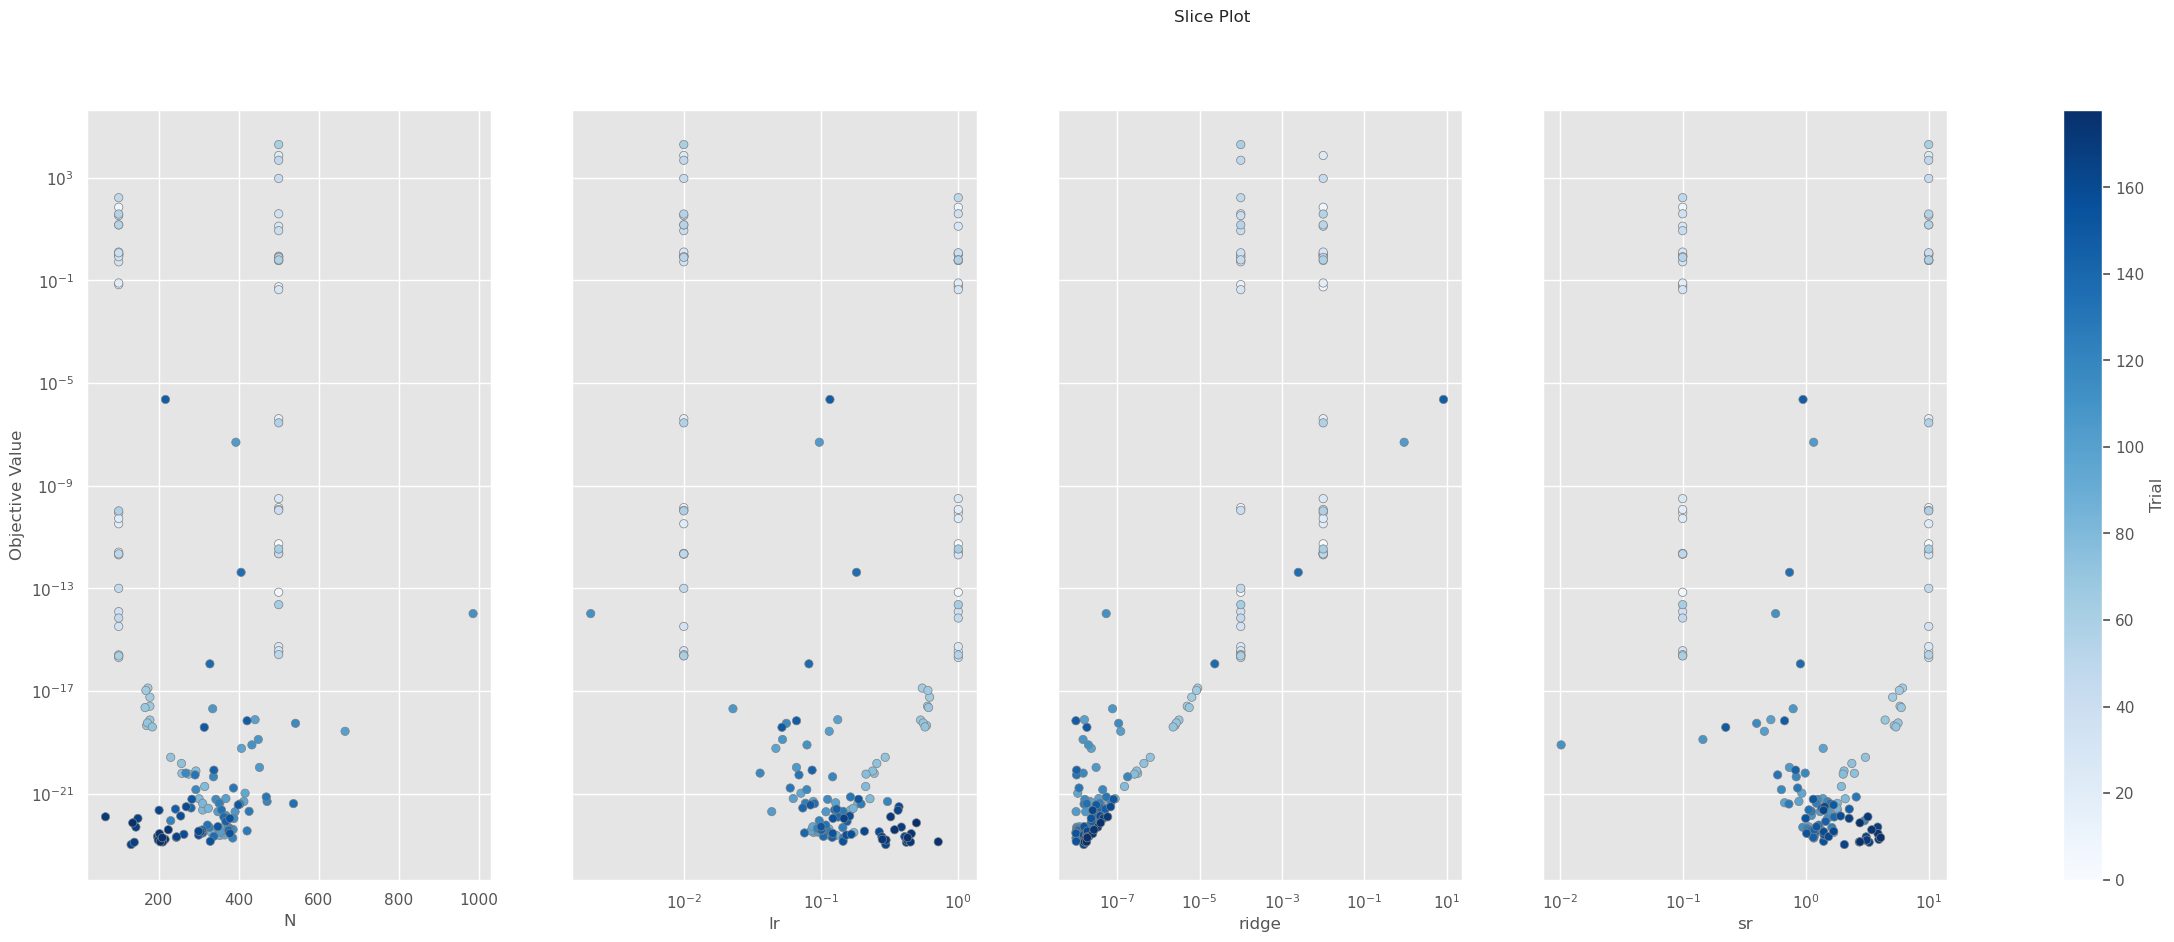

In [17]:
axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
ax = axes[0]
ax.set_yscale("log")

# Baseline + noise on target > Generalization

In [18]:
STUDY_NAME = "Cheat-Noisy-Generalization"
db_name = f"{STUDY_NAME}.db"
df_name = f"{STUDY_NAME}.pkl"
# %rm "$db_name"
storage_name = f"sqlite:///{db_name}"

x_labels = ["x2_x5", "x4_x7"]
y_labels_train = ["y_fixed_obs"]
y_labels_test = ["y_fixed"]


indiv_list = data[SERIES_COLUMN_NAME].unique()
N_indiv = len(indiv_list)
indiv_cut = round(0.8 * N_indiv)

data_train = data[data[SERIES_COLUMN_NAME] < indiv_cut]
data_test = data[data[SERIES_COLUMN_NAME] >= indiv_cut]

processed_data = ProcessedData(
    data_train,
    data_test,
    SERIES_COLUMN_NAME,
    TIMESTEPS_COLUMN_NAME,
    x_labels,
    y_labels_train,
    y_labels_test,
    RobustScaler(),
)

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize"],
    load_if_exists=True,
)

if not study.trials:

    study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
        n_trials=100,
    )

#######################
# study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
# study.optimize(
#     lambda x: optuna_objective(x, processed_data),
#     n_trials=100,
# )
######################

print(f"\n{len(study.trials)} trials found.")

print(f"\nThe best model MSE is: {study.best_value:.2e}")

[I 2024-11-13 15:41:12,324] Using an existing study with name 'Cheat-Noisy-Generalization' instead of creating a new one.


Train and test data prepared with scaler <class 'sklearn.preprocessing._data.RobustScaler'>.

181 trials found.

The best model MSE is: 1.34e-08


## Predictions of the best model

In [19]:
# if Path(df_name).exists() and (
#     Path(df_name).stat().st_mtime > Path(db_name).stat().st_mtime
# ):
#     df_pred = pd.read_pickle(df_name)
#     print(f"'{df_name}' opened")
# else:
#     best_model_list = get_model_list(study.best_trial, x_labels)
#     df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=N_CPUS)
#     df_pred.to_pickle(df_name)

### Worst individual predictions of the best model

In [21]:
# for indiv in get_worst_individuals(
#     df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
# ):
#     plot_individual_results(
#         df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
#     )

## Hyper-parameters analysis

/tmp/ipykernel_17253/3621283914.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])


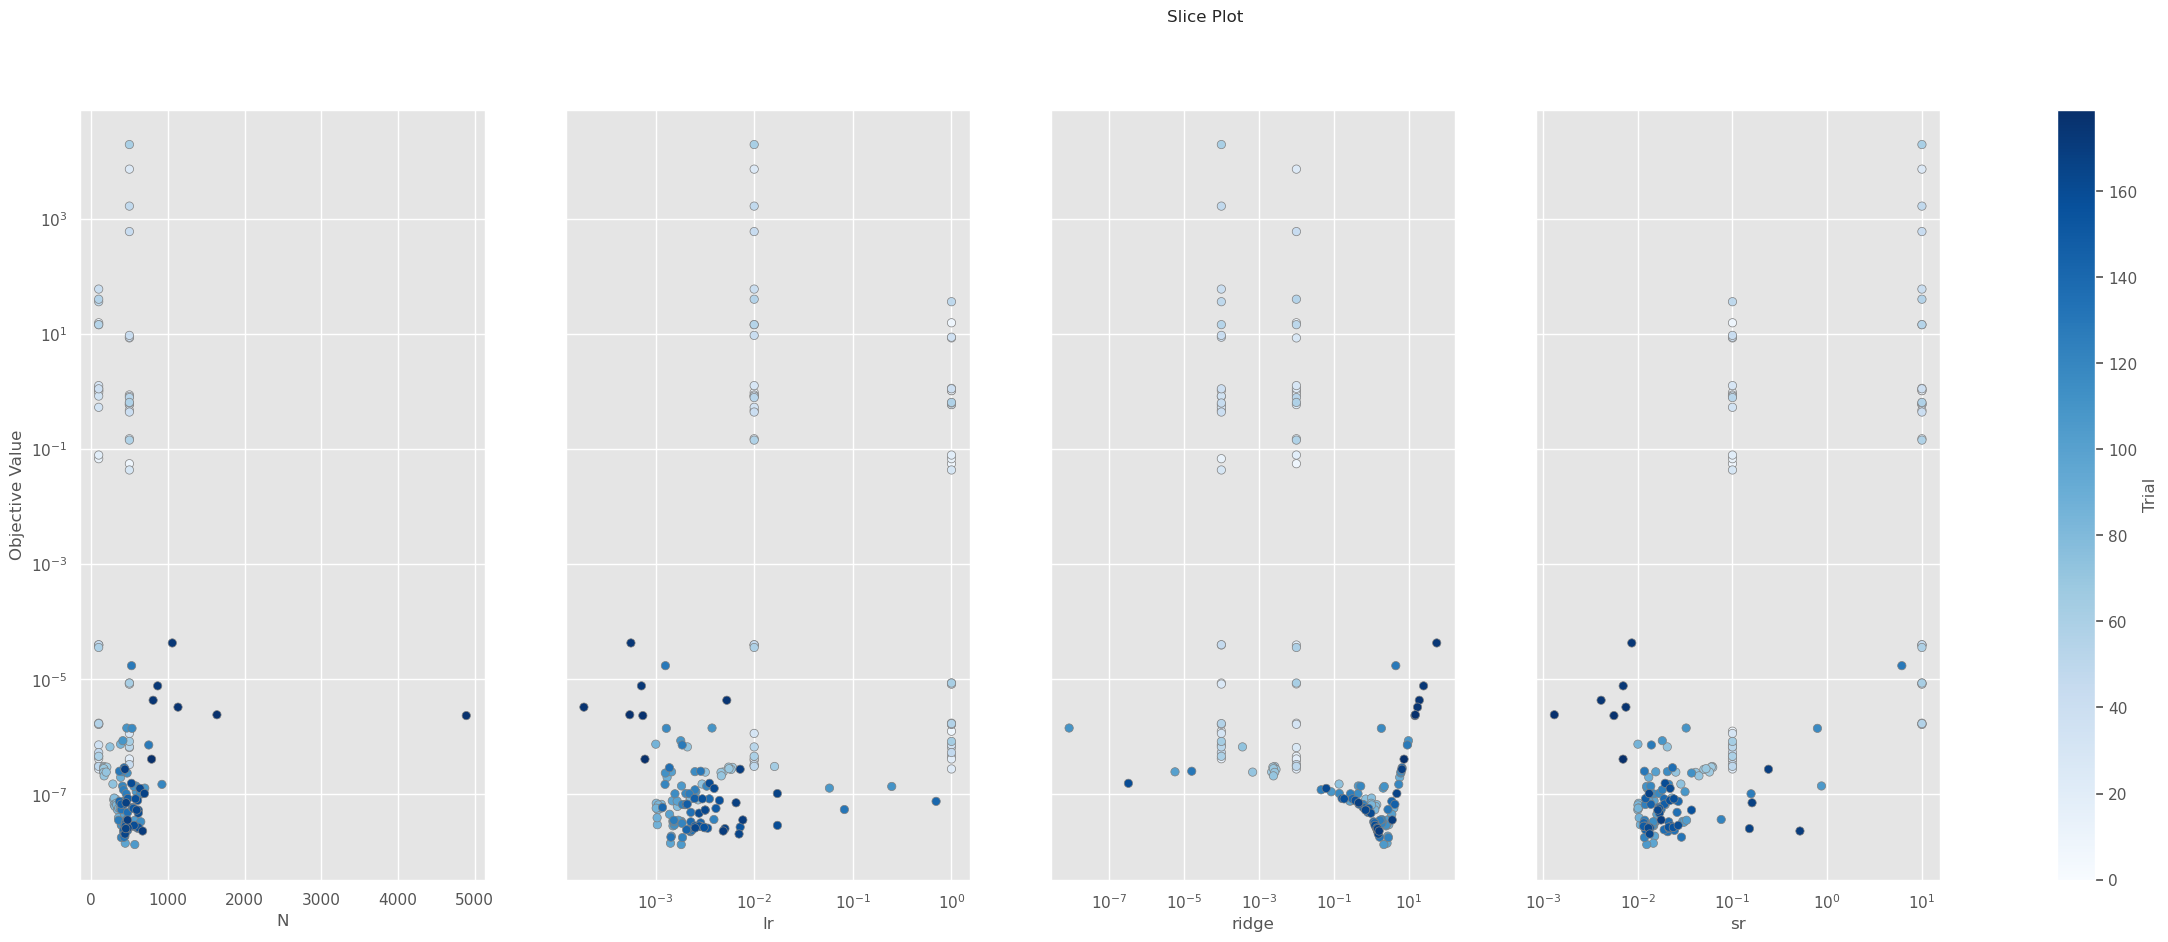

In [22]:
axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
ax = axes[0]
ax.set_yscale("log")

# Baseline + Mixed effects => Capacity

We use:
- features:
  - "x2_x5" and "x4_x7"
  - without noise
- target with random effects

In [23]:
STUDY_NAME = "MixedEffect-Capacity"
db_name = f"{STUDY_NAME}.db"
df_name = f"{STUDY_NAME}.pkl"
# %rm "$db_name"
storage_name = f"sqlite:///{db_name}"

x_labels = ["x2_x5", "x4_x7"]
data_train = data_test = data
y_labels_train = y_labels_test = ["y_mixed"]

processed_data = ProcessedData(
    data_train,
    data_test,
    SERIES_COLUMN_NAME,
    TIMESTEPS_COLUMN_NAME,
    x_labels,
    y_labels_train,
    y_labels_test,
    RobustScaler(),
)

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize"],
    load_if_exists=True,
)

if not study.trials:

    study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
        n_trials=100,
    )

# #######################
# study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
# study.optimize(
#     lambda x: optuna_objective(x, processed_data),
#     n_trials=100,
# )
# ######################

print(f"\n{len(study.trials)} trials found.")

print(f"\nThe best model MSE is: {study.best_value:.2e}")

[I 2024-11-13 15:41:14,952] Using an existing study with name 'MixedEffect-Capacity' instead of creating a new one.


Train and test data prepared with scaler <class 'sklearn.preprocessing._data.RobustScaler'>.

401 trials found.

The best model MSE is: 3.42e-02


## Predictions of the best model

In [24]:
if Path(df_name).exists() and (
    Path(df_name).stat().st_mtime > Path(db_name).stat().st_mtime
):
    df_pred = pd.read_pickle(df_name)
    print(f"'{df_name}' opened")
else:
    best_model_list = get_model_list(study.best_trial, x_labels)
    df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=N_CPUS)
    df_pred.to_pickle(df_name)

'MixedEffect-Capacity.pkl' opened


### Worst individual predictions of the best model

Returning the 2 worst MAE individuals (mean over seeds and timesteps).


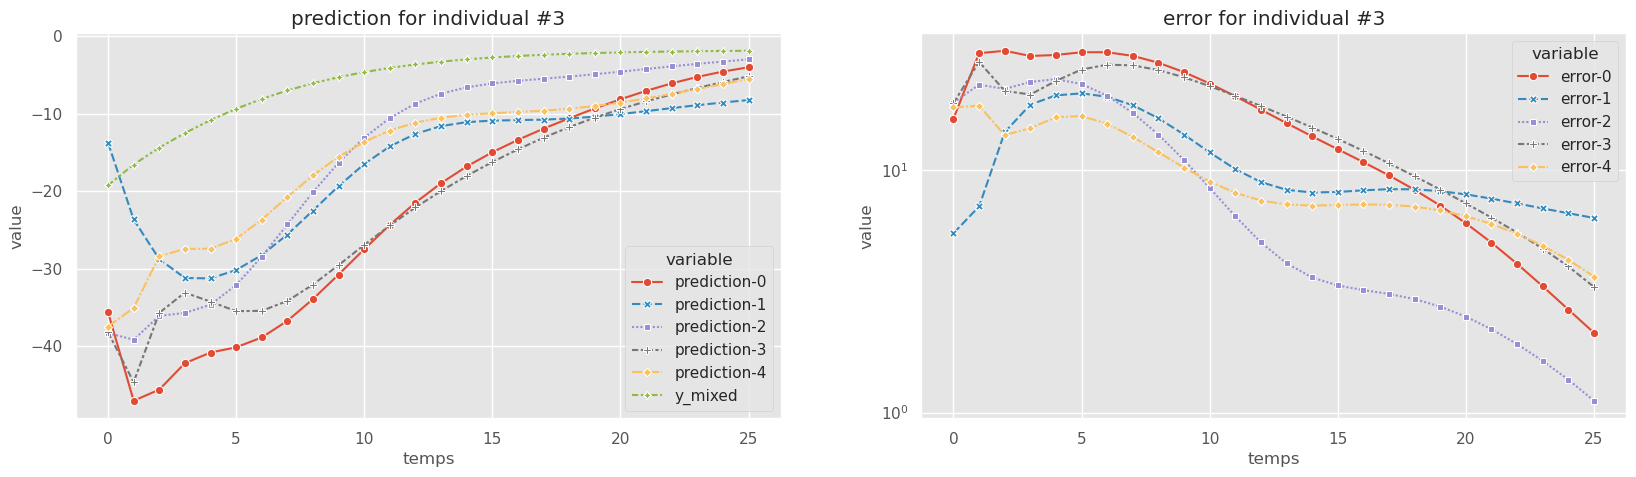

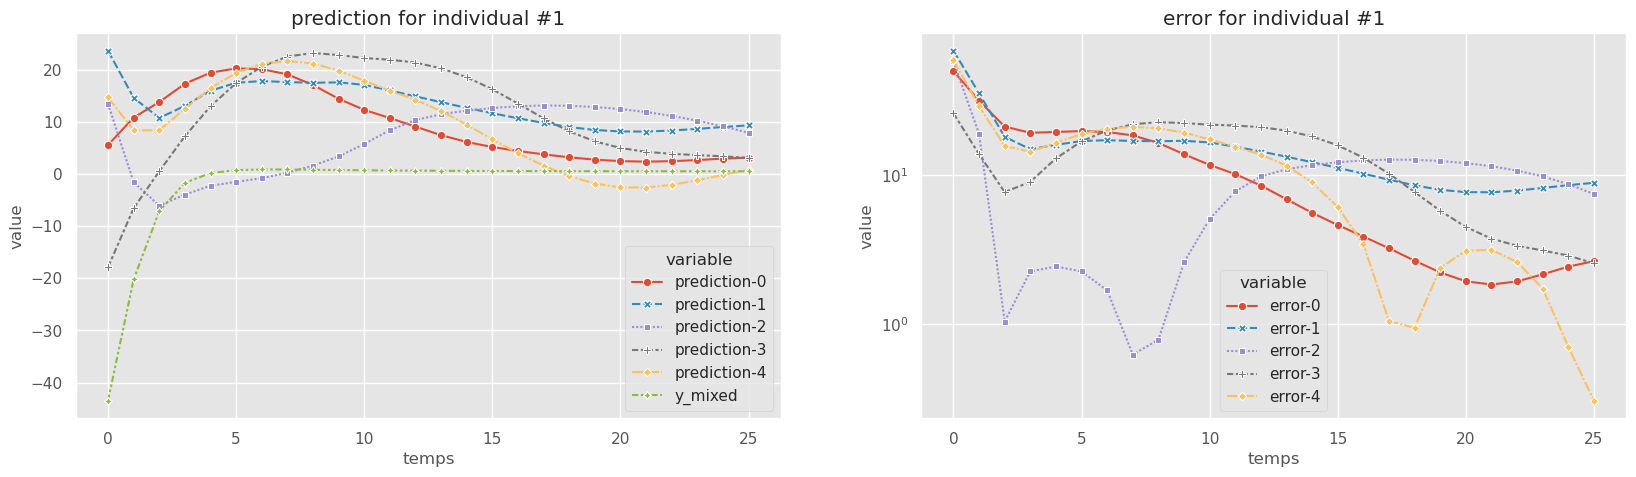

In [ ]:
for indiv in get_worst_individuals(
    df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
):
    plot_individual_results(
        df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
    )

## Hyper-parameters analysis

/tmp/ipykernel_17020/3621283914.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])


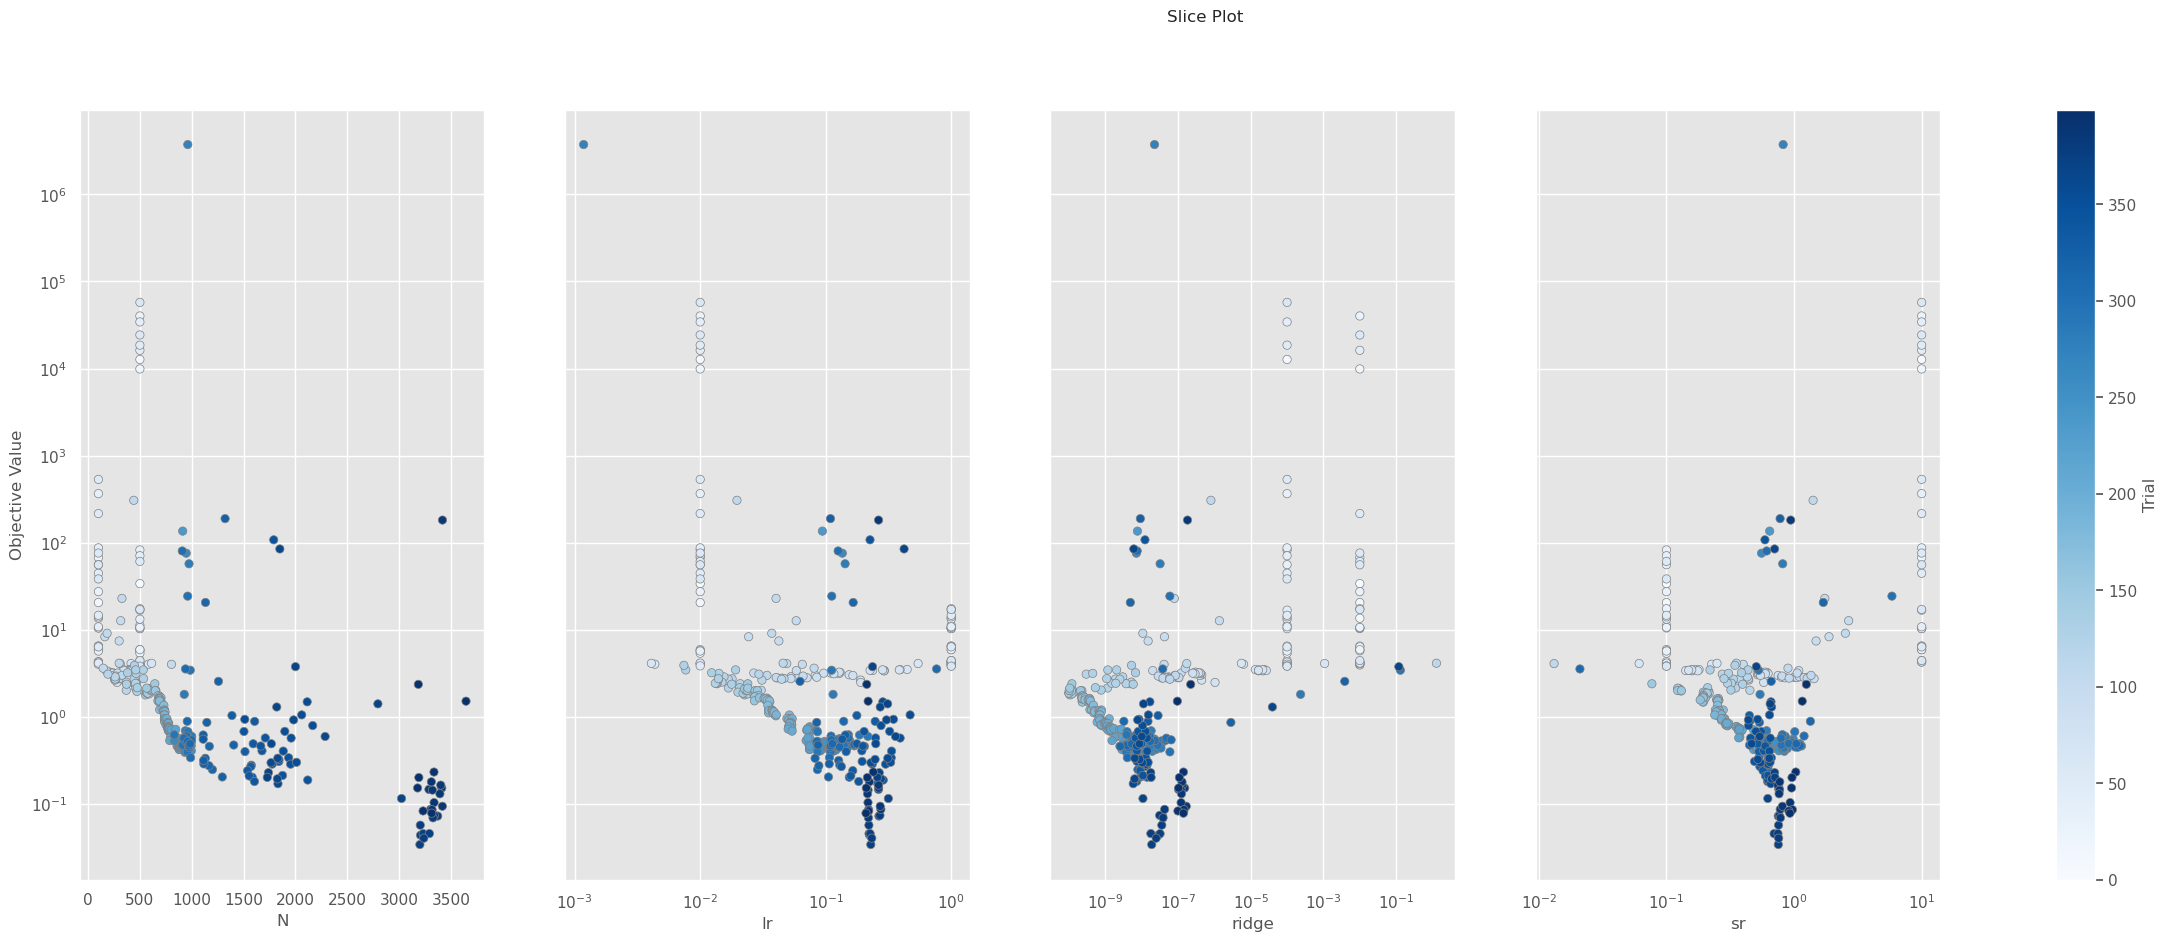

In [ ]:
axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
ax = axes[0]
ax.set_yscale("log")

# Baseline + Mixed effects => Generalization

We use:
- features:
  - "x2_x5" and "x4_x7"
  - without noise
- target with random effects

In [ ]:
STUDY_NAME = "MixedEffect-Generalization"
db_name = f"{STUDY_NAME}.db"
df_name = f"{STUDY_NAME}.pkl"
# %rm "$db_name"
storage_name = f"sqlite:///{db_name}"

x_labels = ["x2_x5", "x4_x7"]
y_labels_train = y_labels_test = ["y_mixed"]

indiv_list = data[SERIES_COLUMN_NAME].unique()
N_indiv = len(indiv_list)
indiv_cut = round(0.8 * N_indiv)

data_train = data[data[SERIES_COLUMN_NAME] < indiv_cut]
data_test = data[data[SERIES_COLUMN_NAME] >= indiv_cut]


processed_data = ProcessedData(
    data_train,
    data_test,
    SERIES_COLUMN_NAME,
    TIMESTEPS_COLUMN_NAME,
    x_labels,
    y_labels_train,
    y_labels_test,
    RobustScaler(),
)

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize"],
    load_if_exists=True,
)

if not study.trials:

    study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
        n_trials=100,
    )

# #######################
# study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
# study.optimize(
#     lambda x: optuna_objective(x, processed_data),
#     n_trials=100,
# )
# ######################

print(f"\n{len(study.trials)} trials found.")

print(f"\nThe best model MSE is: {study.best_value:.2e}")

[I 2024-11-13 15:34:31,431] Using an existing study with name 'MixedEffect-Generalization' instead of creating a new one.


Train and test data prepared with scaler <class 'sklearn.preprocessing._data.RobustScaler'>.

200 trials found.

The best model MSE is: 8.01e+00


## Predictions of the best model

In [ ]:
if Path(df_name).exists() and (
    Path(df_name).stat().st_mtime > Path(db_name).stat().st_mtime
):
    df_pred = pd.read_pickle(df_name)
    print(f"'{df_name}' opened")
else:
    best_model_list = get_model_list(study.best_trial, x_labels)
    df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=N_CPUS)
    df_pred.to_pickle(df_name)

'MixedEffect-Generalization.pkl' opened


### Worst individual predictions of the best model

Returning the 2 worst MAE individuals (mean over seeds and timesteps).


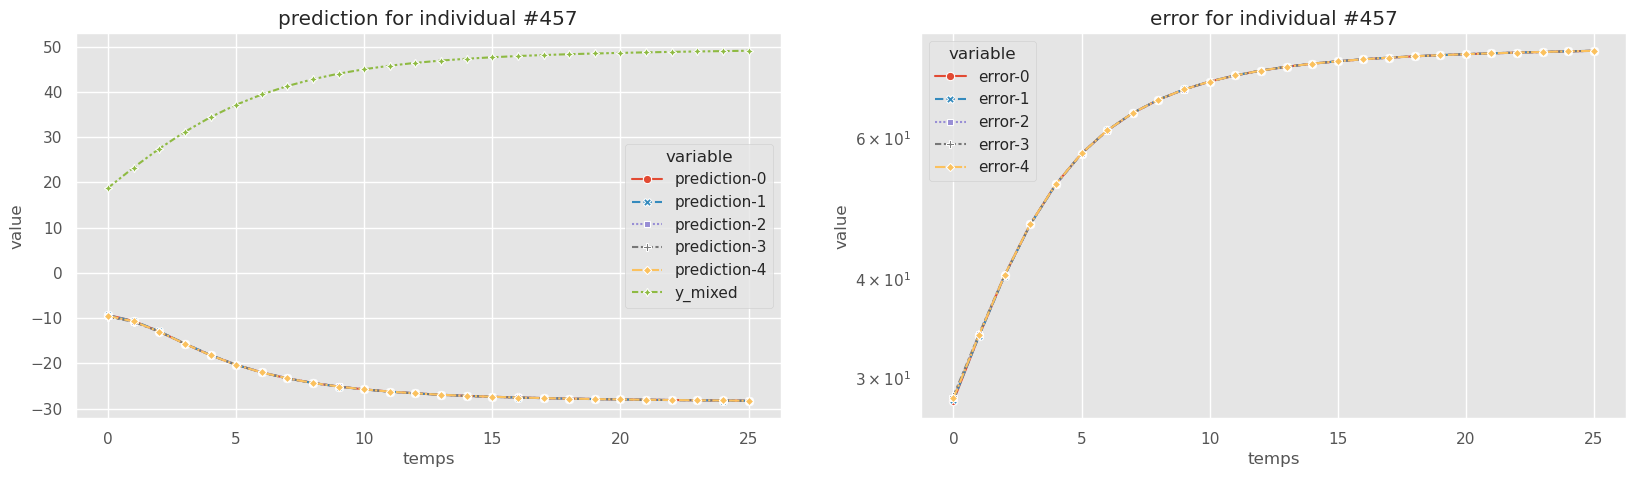

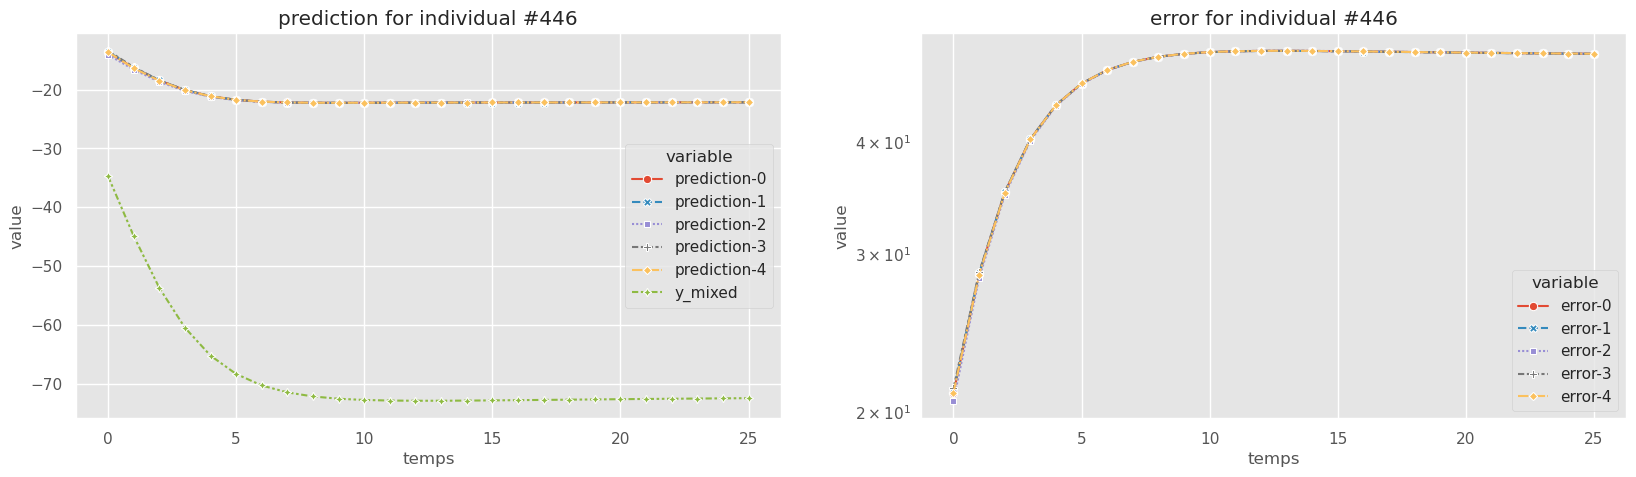

In [ ]:
for indiv in get_worst_individuals(
    df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
):
    plot_individual_results(
        df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
    )

## Hyper-parameters analysis

/tmp/ipykernel_17020/2948150441.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])


(2.851293461717257, 1000.0)

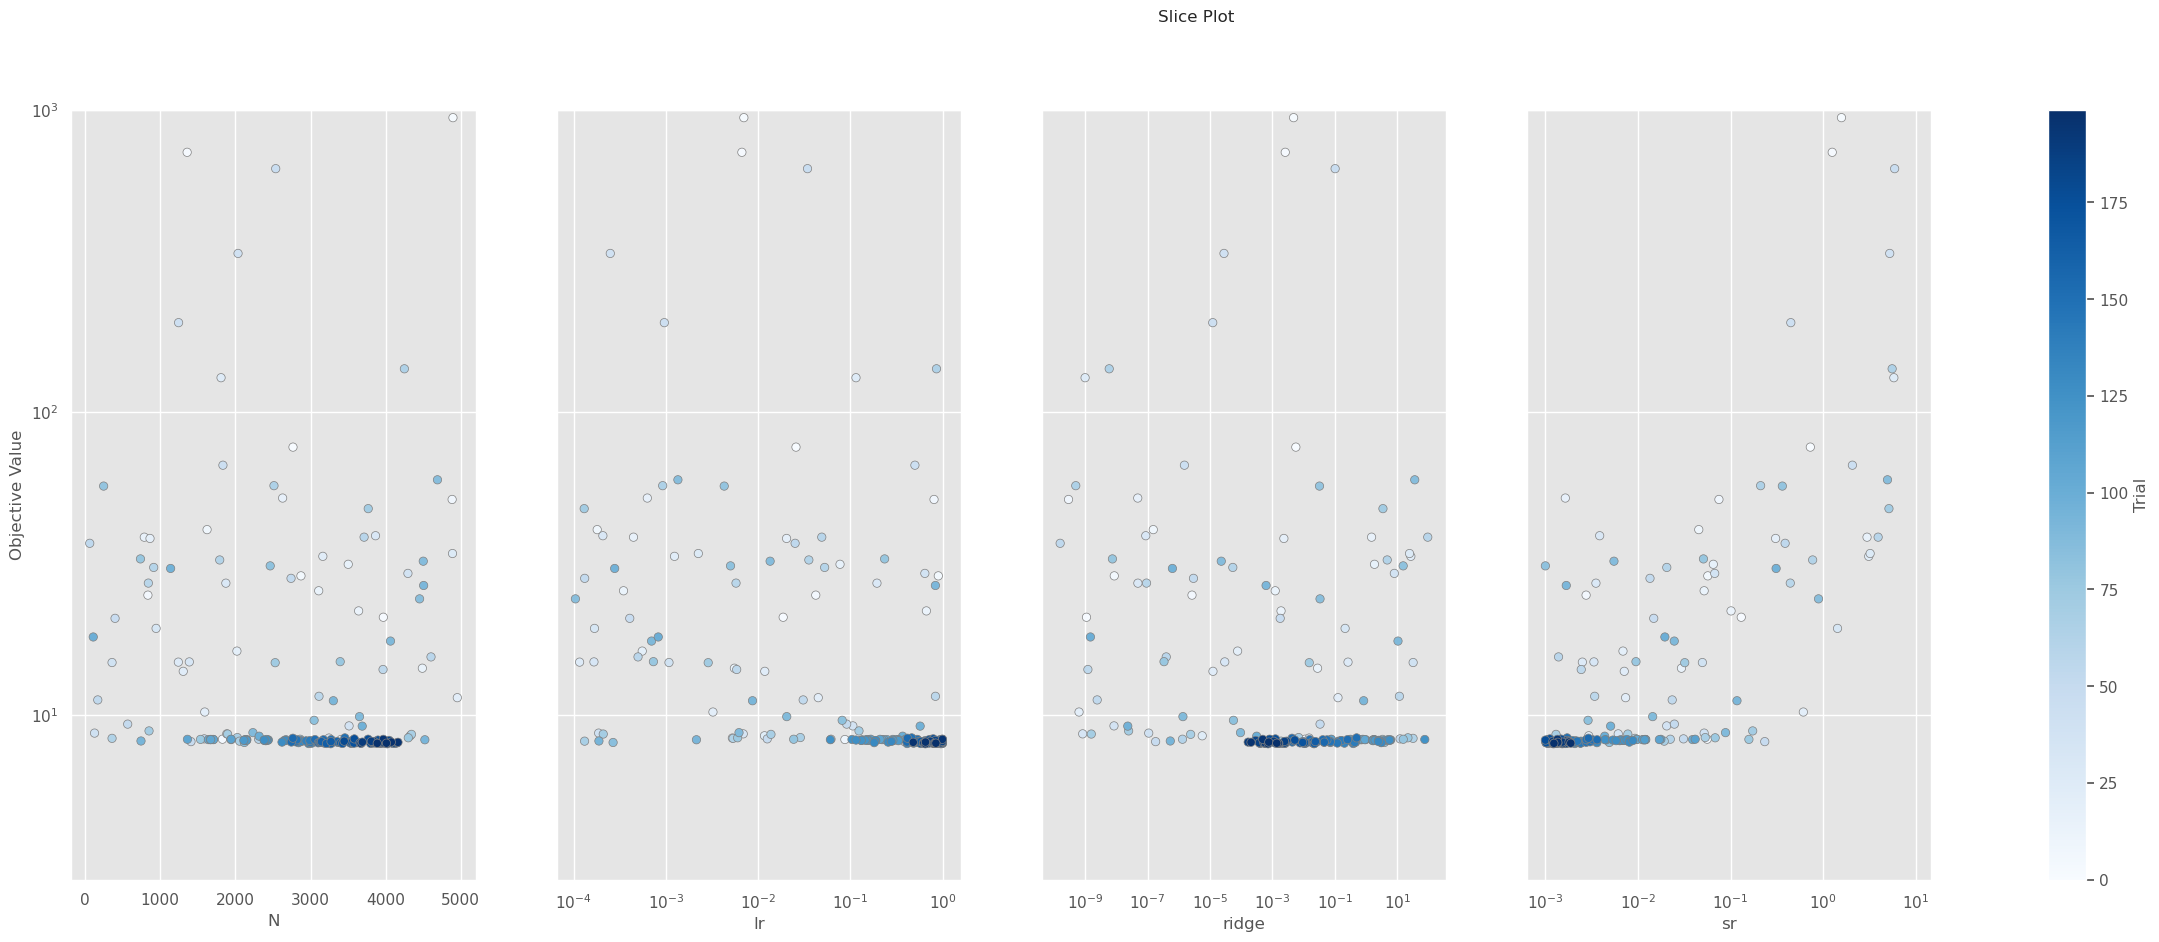

In [ ]:
axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
ax = axes[0]
ax.set_yscale("log")
ax.set_ylim(top=1e3)

# Baseline + Random effects only => Capacity

We use:
- features:
  - "x2_x5" and "x4_x7"
  - without noise
- random effects

In [ ]:
# STUDY_NAME =s "RandomEffect-Capacity"
# db_name = f"{STUDY_NAME}.db"
# df_name = f"{STUDY_NAME}.pkl"
# # %rm "$db_name"
# storage_name = f"sqlite:///{db_name}"

# x_labels = ["x2_x5", "x4_x7"]
# data["y_rand"] = data["y_mixed"] - data["y_fixed"]
# data_train = data_test = data
# y_labels_train = y_labels_test = ["y_rand"]

# processed_data = ProcessedData(
#     data_train,
#     data_test,
#     SERIES_COLUMN_NAME,
#     TIMESTEPS_COLUMN_NAME,
#     x_labels,
#     y_labels_train,
#     y_labels_test,
#     RobustScaler(),
# )

# study = optuna.create_study(
#     study_name=STUDY_NAME,
#     storage=storage_name,
#     directions=["minimize"],
#     load_if_exists=True,
# )

# if not study.trials:

#     study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
#     study.optimize(
#         lambda x: optuna_objective(x, processed_data),
#         n_trials=100,
#     )

# #######################
# # study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
# # study.optimize(
# #     lambda x: optuna_objective(x, processed_data),
# #     n_trials=100,
# # )
# ######################

# print(f"\n{len(study.trials)} trials found.")

# print(f"\nThe best model MSE is: {study.best_value:.2e}")

## Predictions of the best model

In [ ]:
# if Path(df_name).exists() and (
#     Path(df_name).stat().st_mtime > Path(db_name).stat().st_mtime
# ):
#     df_pred = pd.read_pickle(df_name)
#     print(f"'{df_name}' opened")
# else:
#     best_model_list = get_model_list(study.best_trial, x_labels)
#     df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=N_CPUS)
#     df_pred.to_pickle(df_name)

### Worst individual predictions of the best model

In [ ]:
# for indiv in get_worst_individuals(
#     df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
# ):
#     plot_individual_results(
#         df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
#     )

## Hyper-parameters analysis

In [ ]:
# axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
# ax = axes[0]
# ax.set_yscale("log")
# ax.set_ylim(top=1e4)

# All numerical features => Capacity

We use:
- features:
  - all numerical features, so ($x_1, ..., x_7$) **but not** $x_8$
  - without noise
- target without random effects

In [ ]:
STUDY_NAME = "all-numerical-Capacity"
db_name = f"{STUDY_NAME}.db"
df_name = f"{STUDY_NAME}.pkl"
# %rm "$db_name"
storage_name = f"sqlite:///{db_name}"

x_labels = ["x1", "x2", "x3", "x4", "x5", "x6", "x7"]
data_train = data_test = data
y_labels_train = y_labels_test = ["y_fixed"]

processed_data = ProcessedData(
    data_train,
    data_test,
    SERIES_COLUMN_NAME,
    TIMESTEPS_COLUMN_NAME,
    x_labels,
    y_labels_train,
    y_labels_test,
    RobustScaler(),
)

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage_name,
    directions=["minimize"],
    load_if_exists=True,
)

if not study.trials:

    study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
    study.optimize(
        lambda x: optuna_objective(x, processed_data),
        n_trials=100,
    )

#######################
# study.sampler = optuna.samplers.TPESampler(n_startup_trials=50, seed=0)
# study.optimize(
#     lambda x: optuna_objective(x, processed_data),
#     n_trials=100,
# )
######################

print(f"\n{len(study.trials)} trials found.")

print(f"\nThe best model MSE is: {study.best_value:.2e}")

[I 2024-11-13 15:34:37,440] Using an existing study with name 'all-numerical-Capacity' instead of creating a new one.


Train and test data prepared with scaler <class 'sklearn.preprocessing._data.RobustScaler'>.

480 trials found.

The best model MSE is: 3.09e-07


## Predictions of the best model

In [ ]:
# if Path(df_name).exists() and (
#     Path(df_name).stat().st_mtime > Path(db_name).stat().st_mtime
# ):
#     df_pred = pd.read_pickle(df_name)
#     print(f"'{df_name}' opened")
# else:
#     best_model_list = get_model_list(study.best_trial, x_labels)
#     df_pred = get_predictions_dataframe(best_model_list, processed_data, n_cpus=N_CPUS)
#     df_pred.to_pickle(df_name)

### Worst individual predictions of the best model

In [ ]:
# for indiv in get_worst_individuals(
#     df_pred, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, N_warmups=N_WARMUPS, N_worst=2
# ):
#     plot_individual_results(
#         df_pred, indiv, SERIES_COLUMN_NAME, TIMESTEPS_COLUMN_NAME, y_labels_test[0]
#     )

## Hyper-parameters analysis

/tmp/ipykernel_17020/3621283914.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])


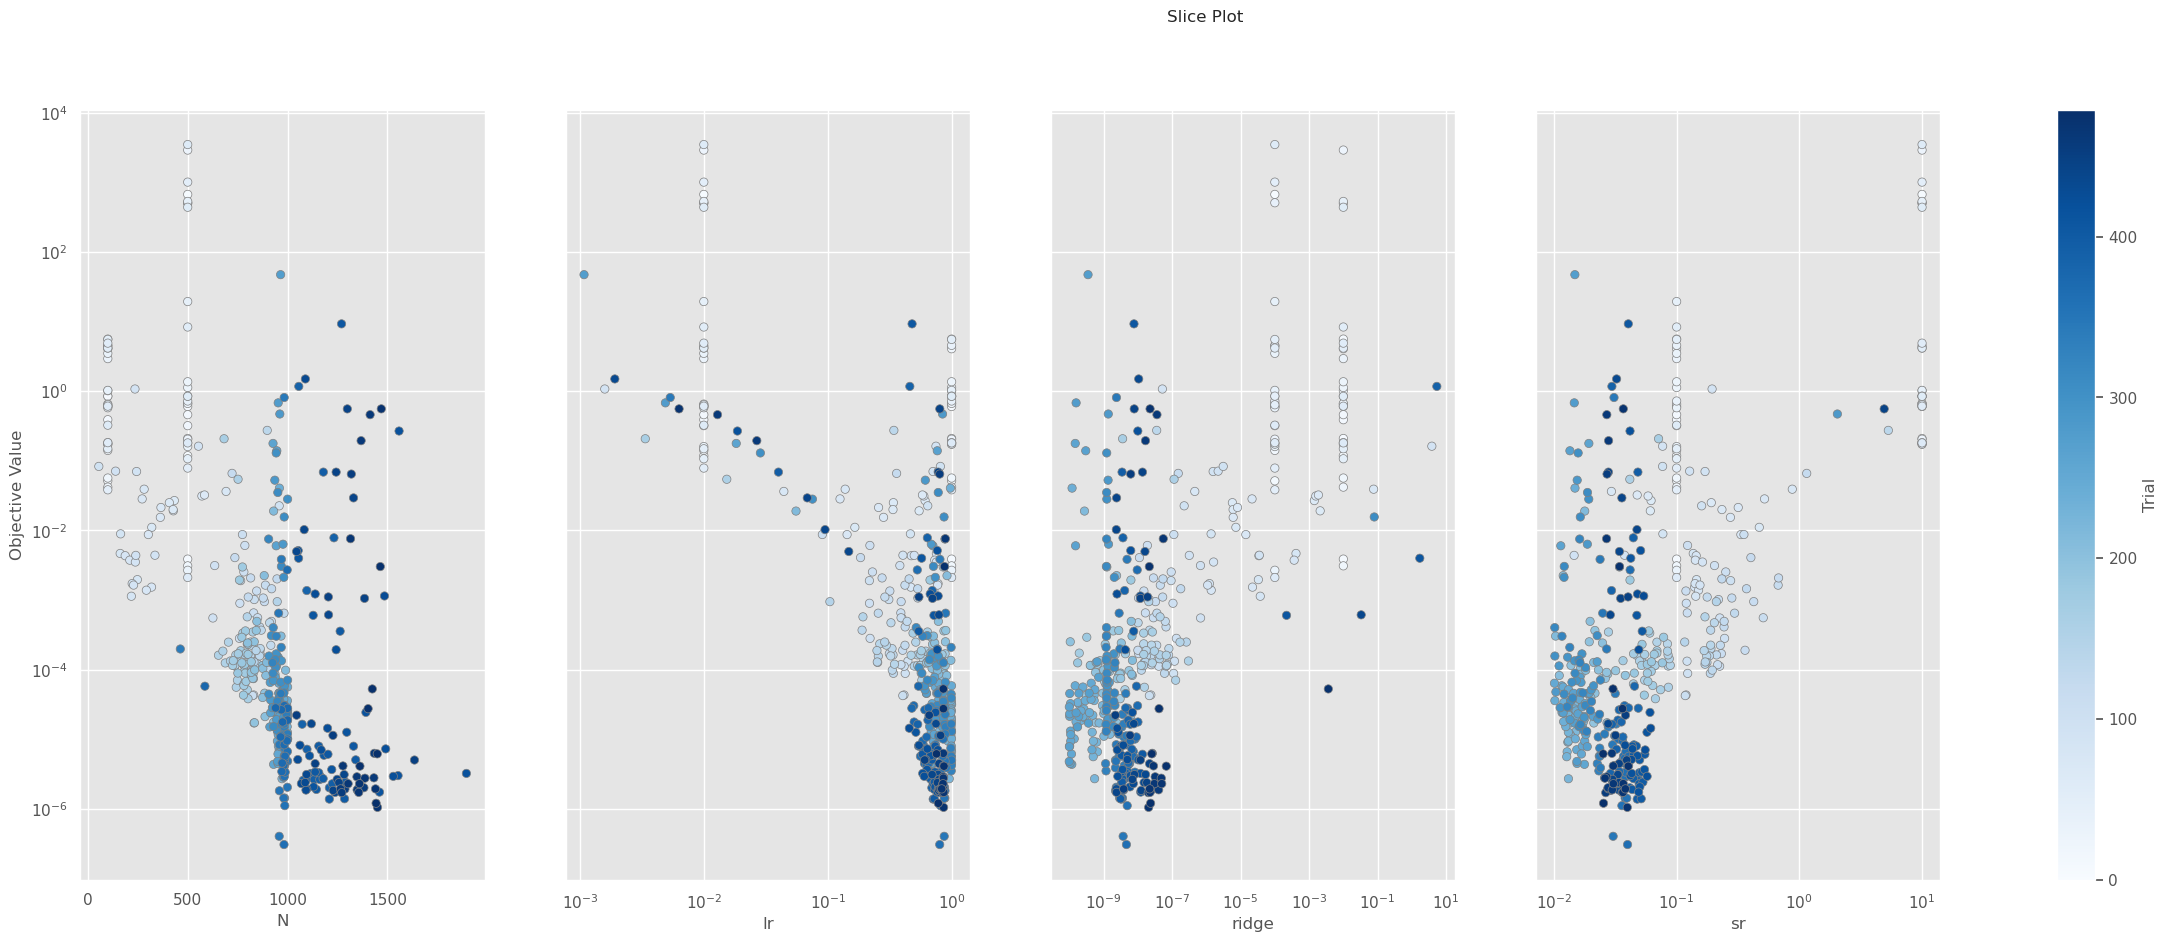

In [ ]:
axes = plot_slice(study, params=["N", "sr", "lr", "ridge"])
ax = axes[0]
ax.set_yscale("log")

We check if the HP optimization helps selecting the informative variables.

These input scalings should be high:

/tmp/ipykernel_17020/1735128556.py:3: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(


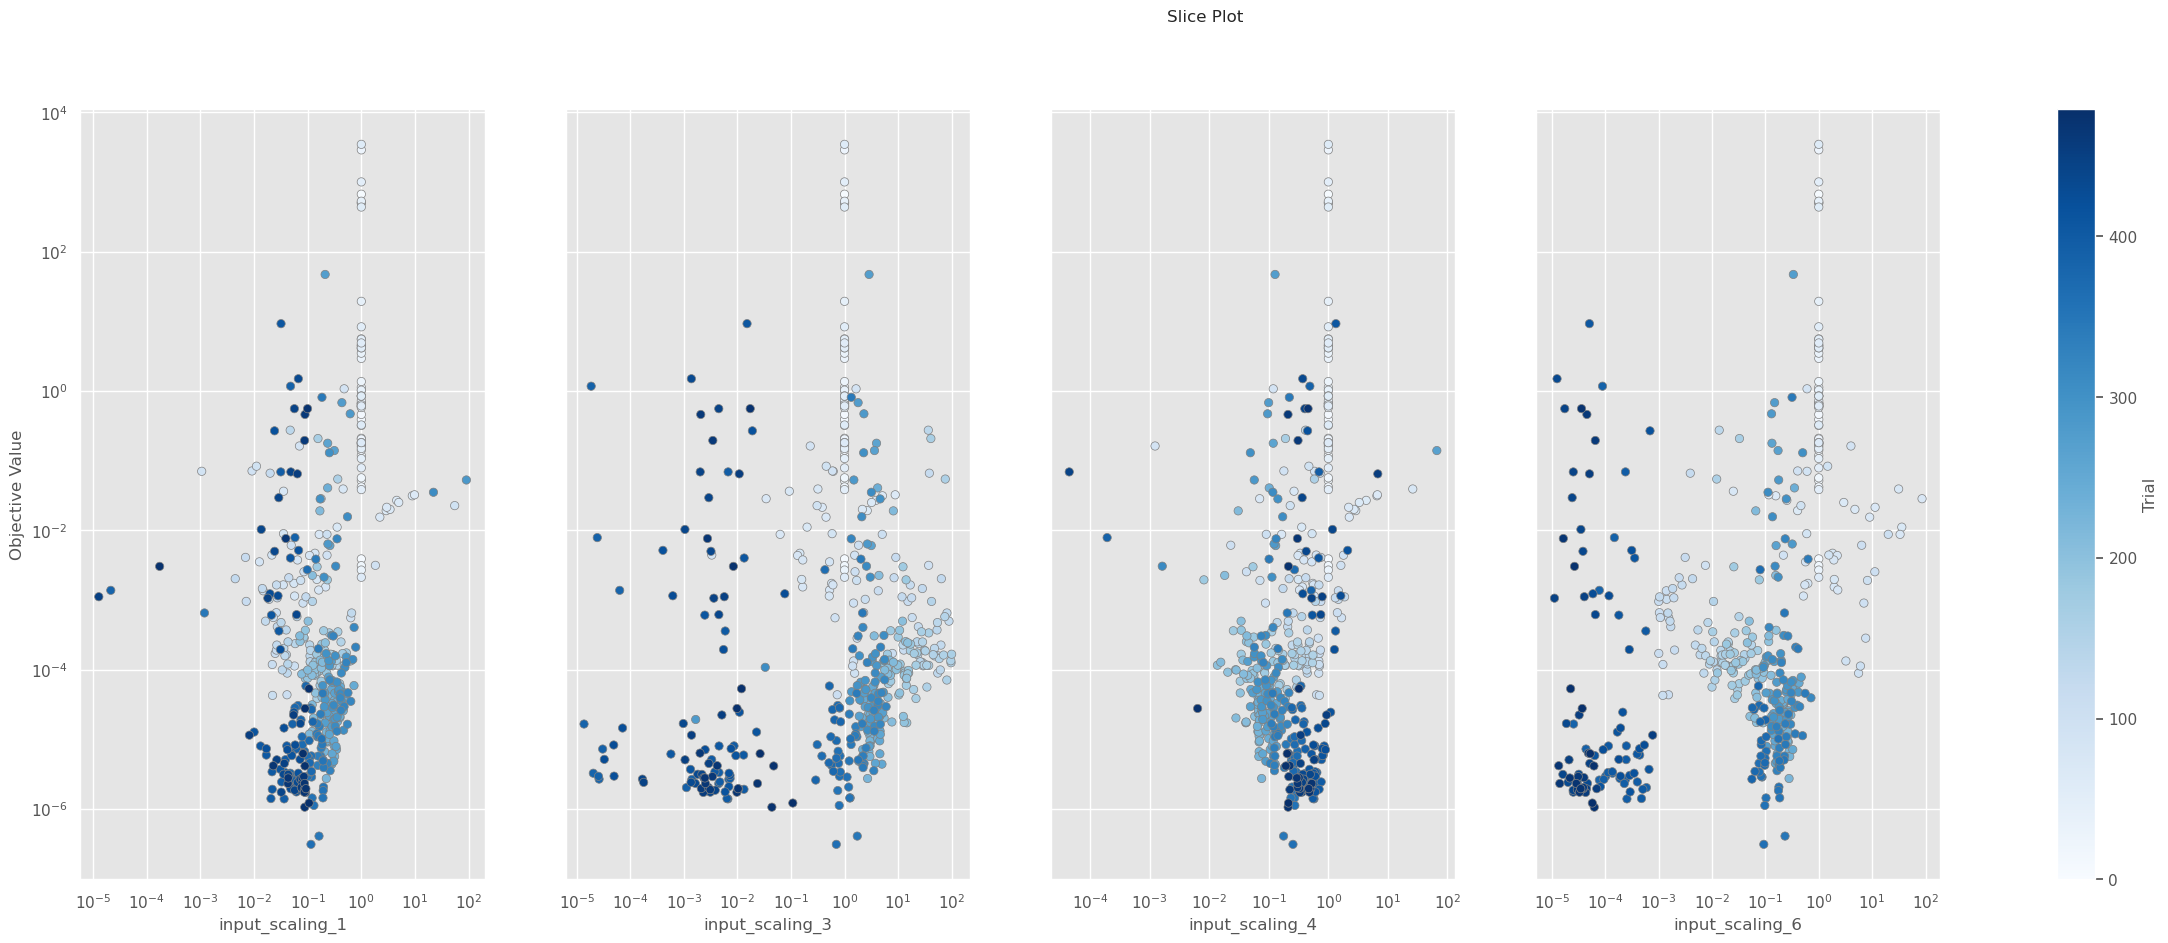

In [ ]:
# "x2_x5" and "x4_x7"

axes = plot_slice(
    study,
    params=[
        # "input_scaling_0", # x1
        "input_scaling_1",  # x2
        # "input_scaling_2", # x3
        "input_scaling_3",  # x4
        "input_scaling_4",  # x5
        # "input_scaling_5", # x6
        "input_scaling_6",  # x7
    ],
)
ax = axes[0]
ax.set_yscale("log")

These input scalings should be low:

/tmp/ipykernel_17020/3483984188.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(


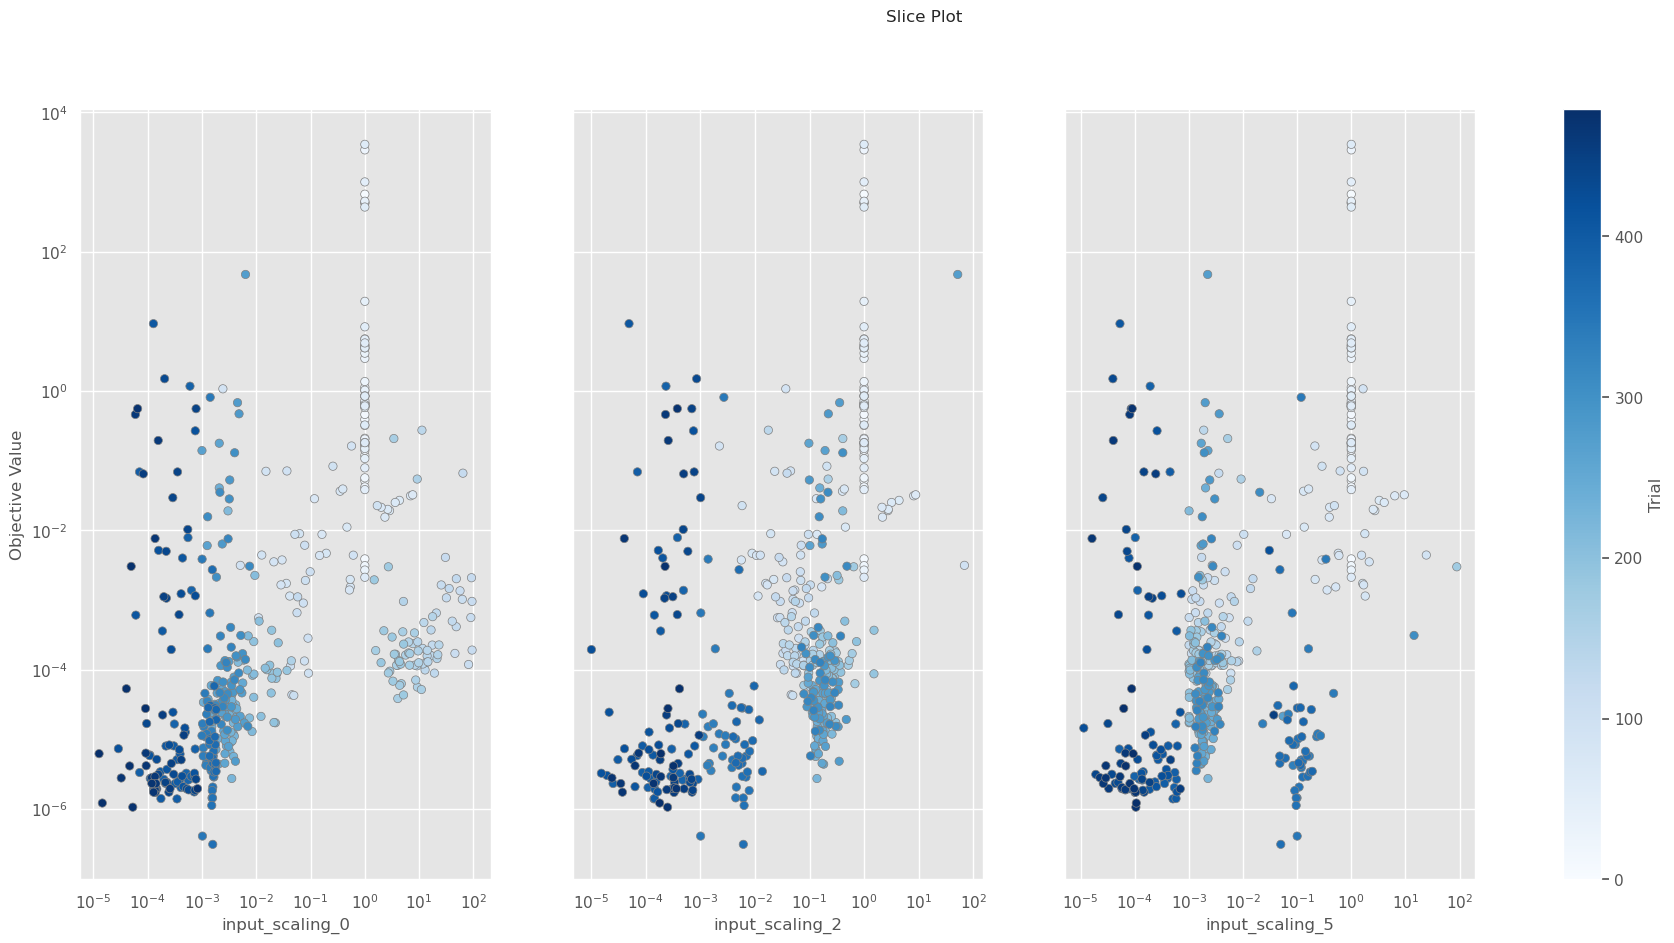

In [ ]:
axes = plot_slice(
    study,
    params=[
        "input_scaling_0",  # x1
        # "input_scaling_1", # x2
        "input_scaling_2",  # x3
        # "input_scaling_3", # x4
        # "input_scaling_4", # x5
        "input_scaling_5",  # x6
        # "input_scaling_6", # x7
    ],
)
ax = axes[0]
ax.set_yscale("log")

There is a tendecy:  
- $1e^{-1}$  for usefull feature  
- $1e^{-3}$  for useless features (… excetp $x_6$ / input_scaling_5)

# Summary

In [ ]:
# ls *.db

In [33]:
studies_titles = {
    "Baseline: Capacity": "Cheat-Capacity",
    "Baseline: Generalization": "Cheat-Generalization",
    "Baseline + Noisy Target": "Cheat-Noisy-Generalization",
    "Baseline + Mixed Effects: Capacity": "MixedEffect-Capacity",
    "Baseline + Mixed Effects: Generalization": "MixedEffect-Generalization",
    # "Baseline + Random Effects: Capacity": "RandomEffect-Capacity",
    "All Num. Features: Capacity": "all-numerical-Capacity",
}

In [34]:
for title, study_name in studies_titles.items():
    db_name = f"{study_name}.db"
    df_name = f"{study_name}.pkl"
    storage_name = f"sqlite:///{db_name}"

    study = optuna.load_study(
        study_name=study_name,
        storage=storage_name,
    )

    print(f"MSE for study {title}: {study.best_value:.2e}")

MSE for study Baseline: Capacity: 8.62e-26
MSE for study Baseline: Generalization: 1.03e-23
MSE for study Baseline + Noisy Target: 1.34e-08
MSE for study Baseline + Mixed Effects: Capacity: 3.42e-02
MSE for study Baseline + Mixed Effects: Generalization: 8.01e+00
MSE for study All Num. Features: Capacity: 3.09e-07


In [ ]:
for title, study_name in studies_titles.items():

    db_name = f"{study_name}.db"
    df_name = f"{study_name}.pkl"
    storage_name = f"sqlite:///{db_name}"

    study = optuna.load_study(
        study_name=study_name,
        storage=storage_name,
    )

    axes = plot_slice(study, params=["N", "lr", "ridge"])
    ax = axes[0]
    ax.set_title(title)
    ax.set_yscale("log")
    ax.set_ylim(top=1e3)

/tmp/ipykernel_17253/2356473882.py:12: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "lr", "ridge"])
/tmp/ipykernel_17253/2356473882.py:12: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "lr", "ridge"])
/tmp/ipykernel_17253/2356473882.py:12: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "lr", "ridge"])
/tmp/ipykernel_17253/2356473882.py:12: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_slice(study, params=["N", "lr", "ridge"])
/tmp/ipykernel_17253/2356473882.py:12: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  axes = plot_sl